# CNN to classify images

## Import libaries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# to hide warnings or atleast some of them (caused by mapping with lambda)
# the warnings are not present in colab
import logging
logging.getLogger("tensorflow").disabled = True

## Load dataset

In [2]:
(train_image, train_label), (test_image, test_label) = tf.keras.datasets.cifar10.load_data()

## Inspect the dataset

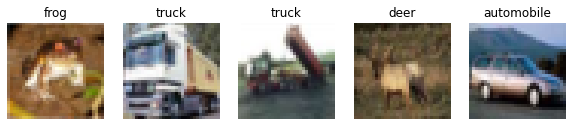

In [4]:
# Declare which number(index) corresponds to which class
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

n = 5
fig, ax = plt.subplots(1, n, figsize=(10,10))
for index, [image, label] in enumerate(zip(train_image[0:n], train_label[0:n])):
    ax[index].imshow(image)
    ax[index].set_title(classes[label[0]])
    ax[index].axis('off')

## Data Augmentation

In [5]:
# set to Falso to run without data augmentation
data_augmentation = True


To get value out of our Data Augmentation we want to create more data points than we originially had

In [6]:
len(train_image)

50000

because we originally had 50,000 images for training 
<br>
we will generate around 256,000 images in total
<br>
<br>
also, because the images are really small we will set the rotation to 0
<br>
to not lose any information

In [7]:
if data_augmentation:
  # create the generator
  train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale=1./255, # do this to avoid problems wiht clipping
      rotation_range=0,
      brightness_range=(0.5,1.5),
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)

  # create an iterator using train_generator.flow
  datagen = train_generator.flow(train_image, train_label, batch_size=64)

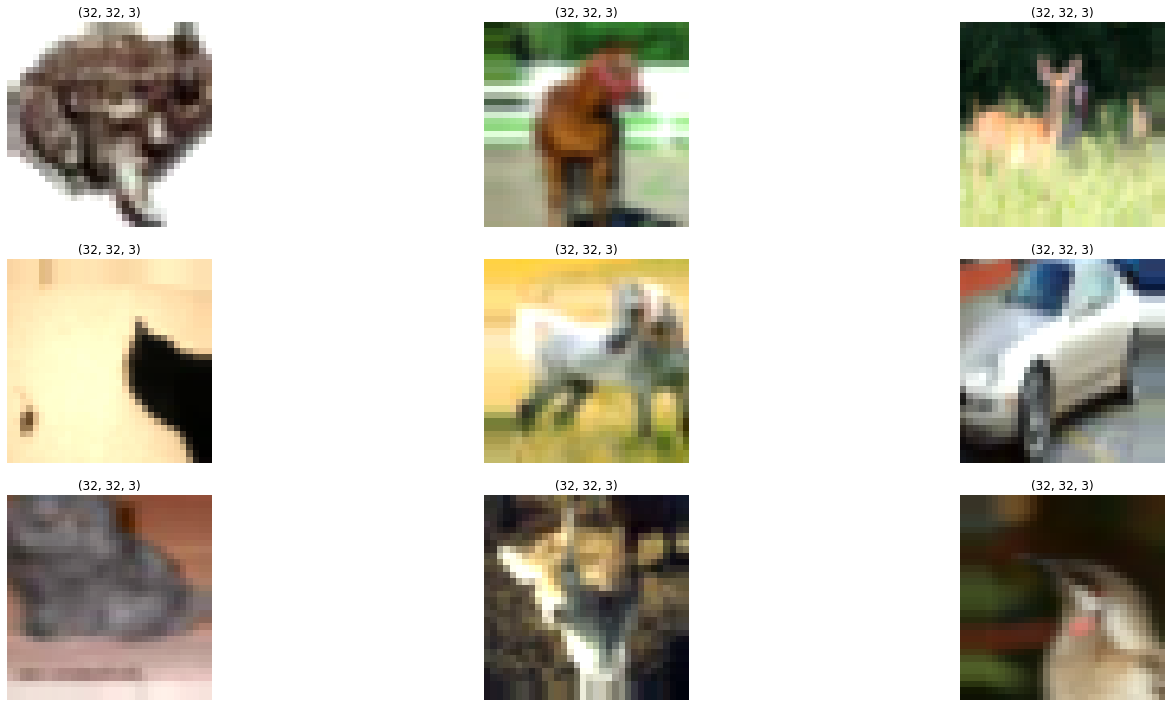

In [8]:
if data_augmentation:
  # plot images of first batch
  fig, ax = plt.subplots(3,3,figsize=(20,10))
  fig.tight_layout()
  ax = ax.flatten()
  for img_b, label_b in datagen:
      for i in range(9):   
          img = img_b[i]
          l = label_b[i]
          
          ax[i].imshow(img)  
          ax[i].set_title((img.shape))
          ax[i].axis("off")

      break   

## Preprocess the data

In [9]:
def generator(num_batches):
    for i, train_tuple in enumerate(datagen):
        yield train_tuple
        if i >= num_batches:
            return

In [10]:
if data_augmentation:
  num_batches = 4000 #1563
  
  # pass generator, outputtypes and num_batches
  # args needs to be tuple of tensors
  train_dataset = tf.data.Dataset.from_generator(generator, (tf.float32, tf.float32), args=(tf.constant(num_batches),))

  # The training data is already batched and scaled to [0,1]

  # shuffle data
  train_dataset = train_dataset.shuffle(64)

  # normalize images and encode labels onehot
  train_dataset = train_dataset.map(lambda image, label: 
                                          (2*(image)-1, tf.squeeze(tf.one_hot(int(label), 10))), 
                                    num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()

  # Prefetch
  train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


  # prepare test dataset
  test_image = tf.data.Dataset.from_tensor_slices(test_image)
  test_label = tf.data.Dataset.from_tensor_slices(test_label)

  test_dataset = tf.data.Dataset.zip((test_image, test_label))

  test_dataset = test_dataset.shuffle(64)                                                

  test_dataset = test_dataset.batch(64)

  test_dataset = test_dataset.map(lambda image, label: 
                                            (2*(image/255)-1, tf.squeeze(tf.one_hot(label, 10))), 
                                    num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()

  test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)                                 

## Without data Augmentation


In [11]:
if not data_augmentation:
  # combine images and labels into a tf dataset
  train_image = tf.data.Dataset.from_tensor_slices(train_image)
  train_label = tf.data.Dataset.from_tensor_slices(train_label)
  test_image = tf.data.Dataset.from_tensor_slices(test_image)
  test_label = tf.data.Dataset.from_tensor_slices(test_label)

  train_dataset = tf.data.Dataset.zip((train_image, train_label))
  test_dataset = tf.data.Dataset.zip((test_image, test_label))                                                
                                                  

  # shuffle data
  train_dataset = train_dataset.shuffle(64)
  test_dataset = test_dataset.shuffle(64)                                                


  # create minibatches
  train_dataset = train_dataset.batch(64)
  test_dataset = test_dataset.batch(64)


  # normalize images and encode labels onehot
  train_dataset = train_dataset.map(lambda image, label: 
                                          (2*(image/255)-1, tf.squeeze(tf.one_hot(label, 10))), 
                                    num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()

  test_dataset = test_dataset.map(lambda image, label: 
                                            (2*(image/255)-1,  tf.squeeze(tf.one_hot(label, 10))), 
                                    num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()


  # different image normalization

  #train_dataset = train_dataset.map(lambda image, label: 
  #                                         (tf.cast(tf.image.per_image_standardization(image),tf.float32), tf.squeeze(tf.one_hot(label, 10))), 
  #                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()

  #test_dataset = test_dataset.map(lambda image, label: 
  #                                          (tf.cast(tf.image.per_image_standardization(image),tf.float32),  tf.squeeze(tf.one_hot(label, 10))), 
  #                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()                                 




  # Prefetch
  train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
  test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Define the model

In [14]:
from tensorflow.keras import Model

class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        self.convolutional_layer_1 = tf.keras.layers.Conv2D(
            filters=256,
            kernel_size=5,
            strides=1,
            padding='same',
            activation='relu',
            #kernel_regularizer=tf.keras.regularizers.l2(0.01),
            input_shape= (32, 32, 3))
        
        self.dropout_1 = tf.keras.layers.Dropout(rate = 0.4)
        
        self.max_pool_1 = tf.keras.layers.MaxPool2D()

        self.convolutional_layer_2 = tf.keras.layers.Conv2D(
            filters=256,
            kernel_size=3,
            padding='same',
            activation='relu',
            #kernel_regularizer=tf.keras.regularizers.l2(0.01)
            )
        
        self.dropout_2 = tf.keras.layers.Dropout(rate = 0.4)
        
        self.max_pool_2 = tf.keras.layers.MaxPool2D()

        self.convolutional_layer_3 = tf.keras.layers.Conv2D(
            filters=512,
            kernel_size=3,
            padding='same',
            activation='relu',
            #kernel_regularizer=tf.keras.regularizers.l2(0.01)
            )
        
        self.dropout_3 = tf.keras.layers.Dropout(rate = 0.4)
        
        self.max_pool_3 = tf.keras.layers.MaxPool2D()

        self.convolutional_layer_4 = tf.keras.layers.Conv2D(
            filters=512,
            kernel_size=2,
            padding='same',
            activation='relu',
            #kernel_regularizer=tf.keras.regularizers.l2(0.01)
            )
        
        self.dropout_4 = tf.keras.layers.Dropout(rate = 0.4)
        
        self.max_pool_4 = tf.keras.layers.MaxPool2D()

        self.convolutional_layer_5 = tf.keras.layers.Conv2D(
            filters=512,
            kernel_size=2,
            padding='same',
            activation='relu',
            #kernel_regularizer=tf.keras.regularizers.l2(0.01)
            )
        
        self.dropout_5 = tf.keras.layers.Dropout(rate = 0.4)
        
        self.max_pool_5 = tf.keras.layers.MaxPool2D()
        
        self.global_average_pooling_layer = tf.keras.layers.GlobalAvgPool2D()

        self.hidden_layer_1 = tf.keras.layers.Dense(
            units=100,
            activation='sigmoid')
        
        self.dropout_6 = tf.keras.layers.Dropout(rate = 0.4)
        
        self.hidden_layer_2 = tf.keras.layers.Dense(
            units=100,
            activation='sigmoid')
        
        self.dropout_7 = tf.keras.layers.Dropout(rate = 0.4)

        self.output_layer = tf.keras.layers.Dense(
            units=10,
            activation='softmax')

    def call(self, x, training = True):
        x = self.convolutional_layer_1(x)
        x = self.dropout_1(x, training)
        x = self.max_pool_1(x)
        x = self.convolutional_layer_2(x)
        x = self.dropout_2(x, training)
        x = self.max_pool_2(x)
        x = self.convolutional_layer_3(x)
        x = self.dropout_3(x, training)
        x = self.max_pool_3(x)
        x = self.convolutional_layer_4(x)
        x = self.dropout_4(x, training)
        x = self.max_pool_4(x)
        x = self.convolutional_layer_5(x)
        x = self.dropout_5(x, training)
        x = self.max_pool_5(x)
        x = self.global_average_pooling_layer(x)
        x = self.hidden_layer_1(x)
        x = self.dropout_6(x, training)
        x = self.hidden_layer_2(x)
        x = self.dropout_7(x, training)
        x = self.output_layer(x)
        return x

## Define traning and testing

In [15]:
def train_step(model, input, target, loss_function, optimizer, training = True):
    with tf.GradientTape() as tape:
        prediction = model(input, training)
        loss = loss_function(target, prediction) #+ tf.reduce_sum(model.losses)
        accuracy = np.mean(np.argmax(target, axis = 1) == np.argmax(prediction, axis = 1))
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, accuracy

def test(model, test_data, loss_function, training = False):
    # Test over complete test data

    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input, training)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  np.mean(np.argmax(target, axis = 1) == np.argmax(prediction, axis = 1))
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(sample_test_accuracy)

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

## Train the model and Plotting accuracy and loss for training and test data.

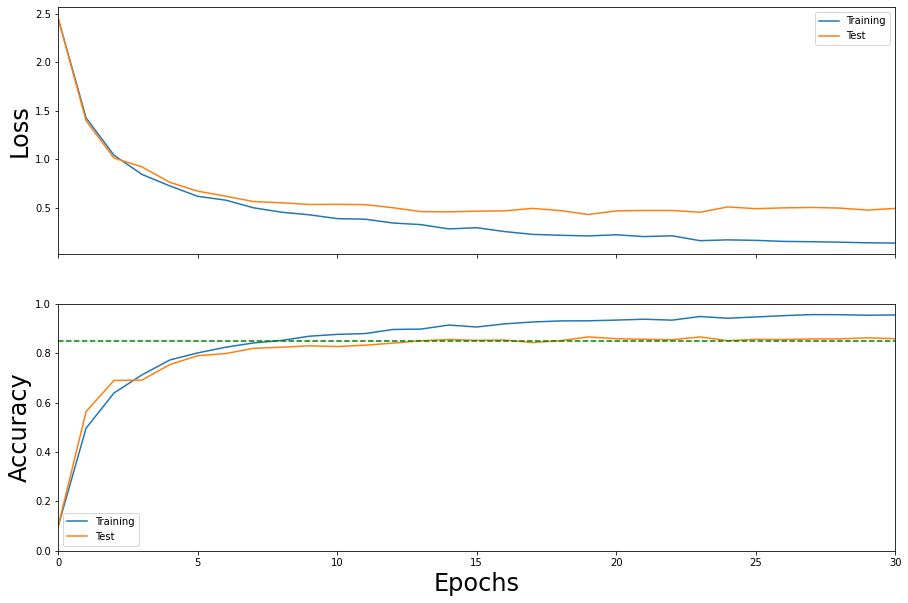

CPU times: user 38min 35s, sys: 1min 53s, total: 40min 28s
Wall time: 1h 14min 1s


In [16]:
%%time
tf.keras.backend.clear_session()
from IPython.display import clear_output

### Hyperparameters
if data_augmentation:
  num_epochs = 30
else:
  num_epochs = 140

learning_rate = 0.0001
running_average_factor = 0.95

model = Model()

# Initialize the loss
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []
train_accuracies = []

test_losses = []
test_accuracies = []

# Testing model performance on train and test data before learning
train_loss, train_accuracy = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# Train loop for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=64)
    test_dataset = test_dataset.shuffle(buffer_size=64)

    # Training
    running_average_loss = 0
    running_average_accuracy = 0
    for (input,target) in train_dataset:
        train_loss, train_accuracy = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * train_loss
        running_average_accuracy = running_average_factor * running_average_accuracy  + (1 - running_average_factor) * train_accuracy
        
        
    train_losses.append(running_average_loss)
    train_accuracies.append(running_average_accuracy)

    # Testing
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    clear_output(wait=True) 
    fontsize=24
    fig, ax = plt.subplots(2,1,sharex=True,figsize=(15,10))
    ax[0].set_xlim((0,num_epochs))
    ax[0].plot(train_losses,label="Training")
    ax[0].plot(test_losses,label="Test")

    ax[1].set_ylim((0,1))
    ax[1].plot(train_accuracies,label="Training")
    ax[1].plot(test_accuracies,label="Test")

    ax[0].set_ylabel("Loss",fontsize=fontsize)
    ax[1].set_ylabel("Accuracy",fontsize=fontsize)
    ax[1].set_xlabel("Epochs",fontsize=fontsize)
    ax[1].axhline(0.85,xmax=num_epochs,c='g',ls='--')
    ax[0].legend()
    ax[1].legend()
    plt.show()

    print('Train loss: ',running_average_loss)
    print('Test loss: ',test_loss)
    print('Train accuracy: ',running_average_accuracy)
    print('Test accuracy: ',test_accuracy, "\n")
    


## Check latest test accuracy

In [18]:
test_accuracies[-1]

0.8583797770700637